In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(18,6)})
pd.set_option('display.max_columns', None)

## Modelling

In [74]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import r2_score, mean_squared_error

from pmdarima.arima import auto_arima

from fbprophet import Prophet

In [62]:
DF_spot_long = pd.read_csv('E:\Academic\DATA & INSIGHTS\Wheat Prices Forecasting\stage_data\spot_long_preprocessed.csv')
DF_spot_long['time'] = pd.to_datetime(DF_spot_long['time'])
DF_spot_long = DF_spot_long.set_index('time')

### Checking TS preperties for Model

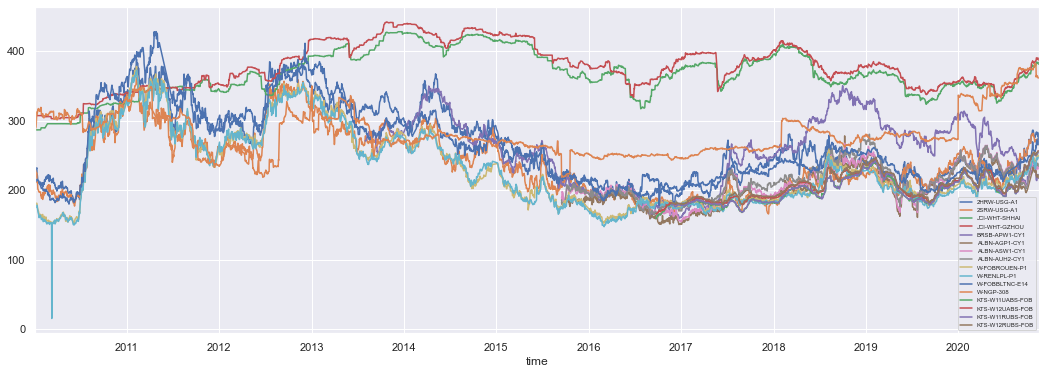

In [63]:
for i in DF_spot_long['Wheat_ID'].unique():
    (DF_spot_long.loc[DF_spot_long['Wheat_ID'] == i, 'price']).plot(label=i)
plt.legend(loc=4, prop={'size': 6})

Throw Visualisation, it can be seen that TS are mostly non-stationary

In [6]:
st_dict = {}
for i in DF_spot_long['Wheat_ID'].unique():
    adfresult = adfuller((DF_spot_long.loc[DF_spot_long['Wheat_ID'] == i,'price']).dropna(), autolag='AIC')
    kpssresult = kpss((DF_spot_long.loc[DF_spot_long['Wheat_ID'] == i,'price']).dropna(), 'ct',nlags="auto")
    st_dict[i] =[adfresult[0], adfresult[1],kpssresult[0],kpssresult[1]]

C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\stattools.py:1882: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\stattools.py:1882: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\stattools.py:1882: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
C:\Users\iti\anacon

In [7]:
pd.DataFrame(st_dict,index=['ada_test', 'ada_p', 'kpss_test', 'kpss_p']).T

,ada_test,ada_p,kpss_test,kpss_p
2HRW-USG-A1,-2.150516,0.224692,0.714546,0.01
2SRW-USG-A1,-2.333987,0.161241,0.836400,0.01
JCI-WHT-SHHAI,-2.582197,0.096733,1.587372,0.01
JCI-WHT-GZHOU,-2.277719,0.179255,1.704725,0.01
BRSB-APW1-CY1,-1.421598,0.571879,1.221800,0.01
ALBN-AGP1-CY1,-2.120297,0.236432,0.287724,0.01
ALBN-ASW1-CY1,-2.028487,0.274224,0.289347,0.01
ALBN-AUH2-CY1,-2.044504,0.267407,0.371874,0.01
W-FOBROUEN-P1,-2.243199,0.190942,0.720735,0.01
W-RENLPL-P1,-1.755679,0.402677,0.728331,0.01


The low P-Value in ADF means stationary ,while in KPSS means non-stationary <br>
By doing the ADF and KPSS tsts it can be seen that all TS are not stationary from both tests

We can try stationarize the data using many methods like (lag diff, decompsition, log, ...) <br>
From practice the log with the lag diff usually efficent and easy to reverse

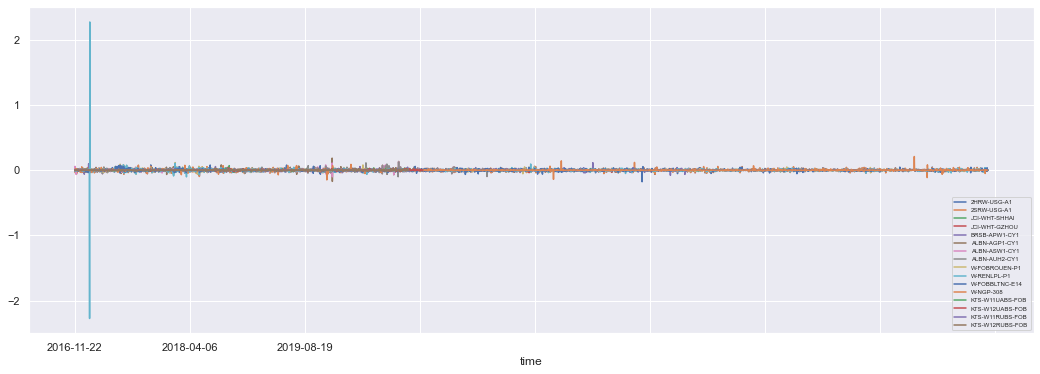

In [8]:
for i in DF_spot_long['Wheat_ID'].unique():
    np.log(DF_spot_long.loc[DF_spot_long['Wheat_ID'] == i, 'price']).diff().plot(label=i)
plt.legend(loc=4, prop={'size': 6})

In [9]:
st_dict = {}
for i in DF_spot_long['Wheat_ID'].unique():
    adfresult = adfuller(np.log(DF_spot_long.loc[DF_spot_long['Wheat_ID'] == i,'price']).diff().dropna(), autolag='AIC')
    kpssresult = kpss(np.log(DF_spot_long.loc[DF_spot_long['Wheat_ID'] == i,'price']).diff().dropna(), 'ct',nlags="auto")
    st_dict[i] =[adfresult[0], adfresult[1],kpssresult[0],kpssresult[1]]

C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
C:\Users\iti\anacon

In [10]:
pd.DataFrame(st_dict,index=['ada_test', 'ada_p', 'kpss_test', 'kpss_p']).T

,ada_test,ada_p,kpss_test,kpss_p
2HRW-USG-A1,-56.472323,0.000000e+00,0.080909,0.100000
2SRW-USG-A1,-59.148667,0.000000e+00,0.063399,0.100000
JCI-WHT-SHHAI,-16.987435,8.920005e-30,0.095521,0.100000
JCI-WHT-GZHOU,-29.667335,0.000000e+00,0.088384,0.100000
BRSB-APW1-CY1,-23.107728,0.000000e+00,0.152078,0.044935
ALBN-AGP1-CY1,-9.532210,2.870661e-16,0.040310,0.100000
ALBN-ASW1-CY1,-9.815513,5.511272e-17,0.036225,0.100000
ALBN-AUH2-CY1,-9.484851,3.786857e-16,0.029534,0.100000
W-FOBROUEN-P1,-11.152299,2.923217e-20,0.168852,0.030957
W-RENLPL-P1,-31.211812,0.000000e+00,0.106232,0.100000


After applying the lag diff with log, the TS have followed more stationary pattern with variable degree but all with very confidence.

In [65]:
DF_spot_long['price_log'] = np.log(DF_spot_long['price'])

In [66]:
ts_log = DF_spot_long.loc[DF_spot_long['Wheat_ID'] == "BRSB-APW1-CY1",'price_log']

In [67]:
lag_acf = acf(ts_log.diff().dropna(), nlags=20)
lag_pacf = pacf(ts_log.diff().dropna(), nlags=20, method='yw')

C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\stattools.py:669: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



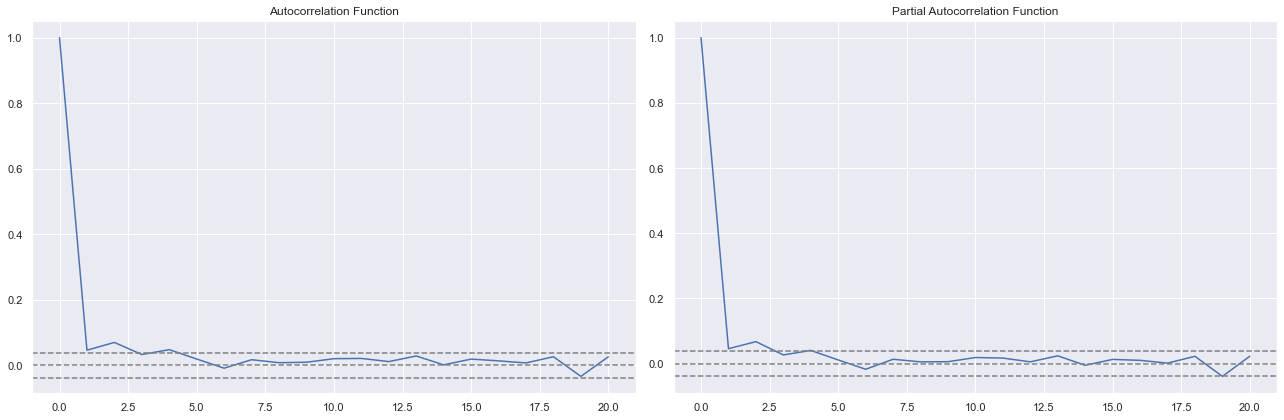

In [68]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

### Modelling with Arima

In [69]:
def Arima_single_ts(ts_log,ts_name: str,p: float,d: int,q: float, plot_diff = False):
    
    model = ARIMA(ts_log.diff(), order=(6, 0, 15))  
    results_AR = model.fit()  
    if plot_diff:
        plt.plot(ts_log.diff(), color='blue')
        plt.plot(results_AR.fittedvalues, color='red')
        plt.title(ts_name + 'RSS: %.4f'% sum((results_AR.fittedvalues-ts_log.diff()).dropna()**2))
        plt.show()
    
    predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues,copy=True)
    predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
    predictions_ARIMA_log = predictions_ARIMA_diff_cumsum + ts_log.iloc[0]
    
    predictions_ARIMA = np.exp(predictions_ARIMA_log)
    ts = np.exp(ts_log)
    plt.plot(ts)
    plt.plot(predictions_ARIMA)
    plt.title(ts_name + 'RMSE: ' + str(np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts))) + " ,R squared " + str(r2_score(ts,predictions_ARIMA)))
    plt.show()

C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



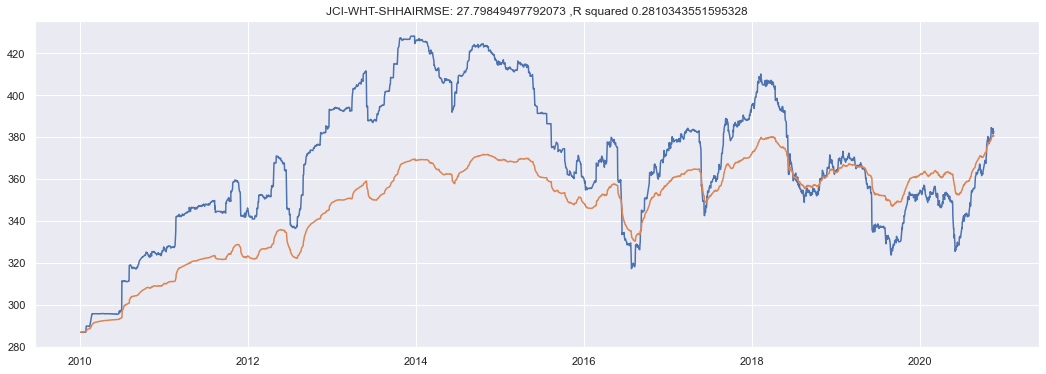

In [70]:
ts_log = DF_spot_long.loc[DF_spot_long['Wheat_ID'] == "JCI-WHT-SHHAI", 'price_log']
Arima_single_ts(ts_log,"JCI-WHT-SHHAI", 6, 0, 15)

C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



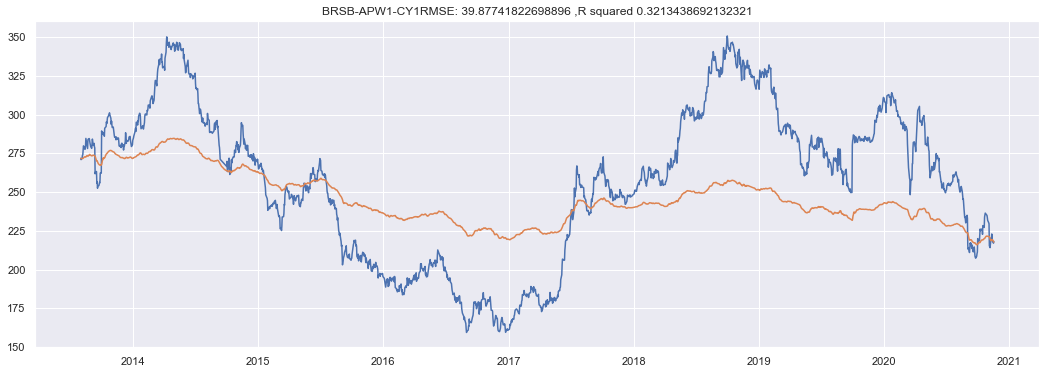

In [71]:
ts_log = DF_spot_long.loc[DF_spot_long['Wheat_ID'] == "BRSB-APW1-CY1", 'price_log']
Arima_single_ts(ts_log,"BRSB-APW1-CY1", 4, 0, 15)

Arima Summary
- Arima is showing variant performance depending on the Wheat ts
- Arima would be difficult to automate as the ACF and PACF need to be checked manually
- no searching for parameers (p,q,d,P, Q,D)is offered as out of the box
- there is a bug in ARIMA statsmodel pkg in "d" after deprication of the old one

### Modelling with Auto Arima

In [26]:
aarima_evaluation_dict= {}
aarima_model_dict={}
for i in DF_spot_long['Wheat_ID'].unique():
    ts_log = DF_spot_long.loc[DF_spot_long['Wheat_ID'] == i, 'price_log']
    ts_log_train = ts_log[-1080:-60]
    ts_log_test = ts_log[-60:]
    arima_model = auto_arima(ts_log_train,
                          start_p=1,
                          d=1,
                          start_q=1,
                          max_p=5,
                          max_q=10,
                          max_d=5,
                          start_P=0,
                          start_Q=0,
                          D=1,
                          max_P=5,
                          max_Q=5,
                          m=4,
                          seasonal=True,
                          supress_warnings=True,
                          n_fits=25,
                          random_state=1)
    predictions_AARIMA = pd.DataFrame(arima_model.predict(n_periods=60), index=ts_log_test.index,columns=['prediction'])
    aarima_evaluation_dict[i] = [mean_squared_error(np.exp(ts_log_test), np.exp(predictions_AARIMA)),r2_score(np.exp(ts_log_test), np.exp(predictions_AARIMA)) ]
    aarima_model_dict[i] = arima_model
    print(i + " RMSE: " + str(np.sqrt(mean_squared_error(np.exp(ts_log_test), np.exp(predictions_AARIMA)))) + " R2: " + str(r2_score(np.exp(ts_log_test), np.exp(predictions_AARIMA))))

C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check

In [ ]:
# pd.DataFrame(aarima_evaluation_dict).T.rename({0: 'RMSE', 1:'R2'},axis=1).to_csv('drive/My Drive/CoLab/Wheat Prices Forecasting/stage_data/aarima_performance.csv')

In [55]:
pd.read_csv('E:\\Academic\\DATA & INSIGHTS\\Wheat Prices Forecasting\\output_data\\aarima_fut_performance.csv')

,Unnamed: 0,RMSE,R2
0,2HRW-USG-A1,202.655424,-0.605455
1,2SRW-USG-A1,120.055304,-0.368048
2,JCI-WHT-SHHAI,15.034525,0.757561
3,JCI-WHT-GZHOU,14.383140,0.771306
4,BRSB-APW1-CY1,1495.917003,-19.726626
5,ALBN-AGP1-CY1,537.881843,-3.507300
6,ALBN-ASW1-CY1,747.009118,-3.838382
7,ALBN-AUH2-CY1,1001.165944,-3.449551
8,W-FOBROUEN-P1,103.059453,-0.553000
9,W-RENLPL-P1,76.395780,-0.108985


In [17]:
 aarima_pred_dict = {}
 for k, v in  aarima_model_dict.items():
   predictions_AARIMA = v.predict(n_periods=150)
   aarima_pred_dict[k] = np.exp(predictions_AARIMA)

NameError: name 'arima_model' is not defined

In [ ]:
# pd.DataFrame(aarima_pred_dict,index=pd.date_range('2020-09-15','2021-02-11')).to_csv('drive/My Drive/CoLab/Wheat Prices Forecasting/stage_data/AArima_Spot_3Month_forecasting.csv')

Visualising Prediction

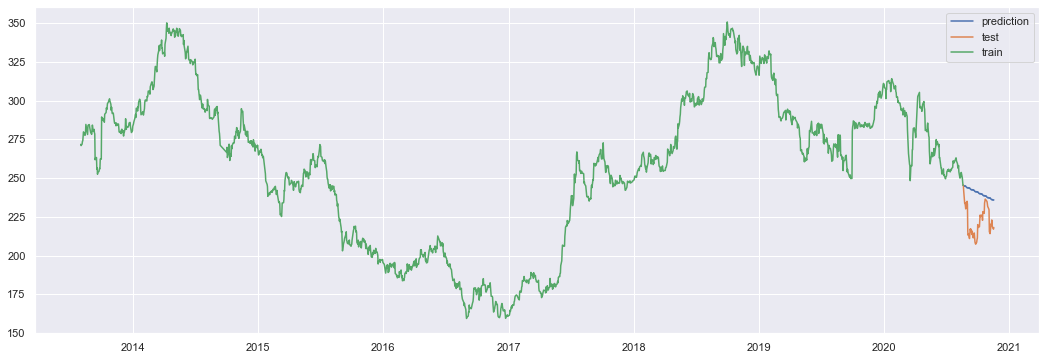

In [72]:
predictions_AARIMA = pd.DataFrame(aarima_model_dict['JCI-WHT-SHHAI'].predict(n_periods=90), index=ts_log_test.index,columns=['prediction'])

plt.plot(np.exp(ts_log_train),label='train')
plt.plot(np.exp(predictions_AARIMA),label='prediction')
plt.plot(np.exp(ts_log_test),label='test')
plt.legend()
plt.xticks(rotation=45)
plt.title("RMSE: " + str(mean_squared_error(np.exp(ts_log_test), np.exp(predictions_AARIMA))) + " R2: " + str(r2_score(np.exp(ts_log_test), np.exp(predictions_AARIMA))))
plt.show()

AutoArima Summary:
- AutoArima allowed the automated modelling of multible TS
- AutoArima consumes avery high resources, so this block was excuted on google CoLab
- Similar to Arima, some TS shows better performance thn others

### FBProphet

In [83]:
FB_evaluation_dict= {}
FB_model_dict={}
for i in DF_spot_long['Wheat_ID'].unique():
    ts = DF_spot_long.loc[DF_spot_long['Wheat_ID'] == i, ['price']]
    ts = ts.reset_index().rename({'time': 'ds', 'price': 'y'},axis=1)
    ts_train = ts[-1080:-60]
    ts_test = ts[-60:]
    
    model = Prophet()
    model.fit(ts_train)
    
    future = model.make_future_dataframe(periods=60)
    FB_prediction = model.predict(future)
    
    
    FB_evaluation_dict[i] = [np.sqrt(mean_squared_error(ts_test['y'], FB_prediction['yhat'][-60:])),r2_score(ts_test['y'], FB_prediction['yhat'][-60:]) ]
    FB_model_dict[i] = model
    
    print(i + " RMSE: " + str(np.sqrt(mean_squared_error(ts_test['y'], FB_prediction['yhat'][-60:]))) + " R2: " + str(r2_score(ts_test['y'], FB_prediction['yhat'][-60:])))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2HRW-USG-A1 RMSE: 27.166932229143345 R2: -4.8468403885906115


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2SRW-USG-A1 RMSE: 20.689102345827326 R2: -3.877567437424381


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


JCI-WHT-SHHAI RMSE: 13.40868127892547 R2: -1.8992461399303475


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


JCI-WHT-GZHOU RMSE: 4.849315741139444 R2: 0.6260944169391138


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BRSB-APW1-CY1 RMSE: 8.48105655672914 R2: 0.003399670289080059


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ALBN-AGP1-CY1 RMSE: 15.752597874556274 R2: -1.079380564741415


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ALBN-ASW1-CY1 RMSE: 15.93414161958312 R2: -0.644491432255355


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ALBN-AUH2-CY1 RMSE: 16.809629362407946 R2: -0.2558171873900159


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


W-FOBROUEN-P1 RMSE: 7.976069604427836 R2: 0.041346967530585865


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


W-RENLPL-P1 RMSE: 8.768731629471837 R2: -0.11616867647768281


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


W-FOBBLTNC-E14 RMSE: 4.344350020008599 R2: 0.8285199400585352


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


W-NGP-308 RMSE: 8.629860019847836 R2: -1.8660951030301276


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KTS-W11UABS-FOB RMSE: 7.596514454001232 R2: 0.32742260102216114


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KTS-W12UABS-FOB RMSE: 9.002702444015203 R2: 0.05043598996748566


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KTS-W11RUBS-FOB RMSE: 10.848511160692937 R2: -0.38274648385280896
KTS-W12RUBS-FOB RMSE: 8.81901419575151 R2: 0.093196657062241


In [86]:
pd.DataFrame(FB_evaluation_dict).T.rename({0: 'RMSE', 1:'R2'},axis=1)\
#.to_csv('E:\Academic\DATA & INSIGHTS\Wheat Prices Forecasting\output_data/FB_fut_performance.csv')

,RMSE,R2
2HRW-USG-A1,27.166932,-4.846840
2SRW-USG-A1,20.689102,-3.877567
JCI-WHT-SHHAI,13.408681,-1.899246
JCI-WHT-GZHOU,4.849316,0.626094
BRSB-APW1-CY1,8.481057,0.003400
ALBN-AGP1-CY1,15.752598,-1.079381
ALBN-ASW1-CY1,15.934142,-0.644491
ALBN-AUH2-CY1,16.809629,-0.255817
W-FOBROUEN-P1,7.976070,0.041347
W-RENLPL-P1,8.768732,-0.116169


In [90]:
 FB_pred_dict = {}
 for k, v in  FB_model_dict.items():
    future = v.make_future_dataframe(periods=150)
    FB_prediction = model.predict(future)
    FB_pred_dict[k] = FB_prediction['yhat'][-150:].values

In [93]:
 pd.DataFrame(FB_pred_dict,index=pd.date_range('2020-09-15','2021-02-11'))\
#.to_csv('E:\Academic\DATA & INSIGHTS\Wheat Prices Forecasting\output_data/FB_Spot_3Month_forecasting.csv')

Visualizing predictions

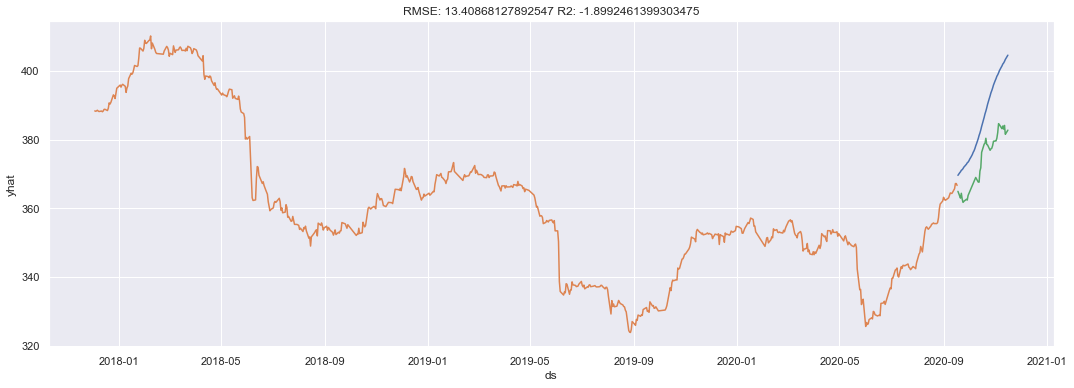

In [96]:
ts = DF_spot_long.loc[DF_spot_long['Wheat_ID'] == "JCI-WHT-SHHAI", ['price']]
ts = ts.reset_index().rename({'time': 'ds', 'price': 'y'},axis=1)
ts_train = ts[-1080:-60]
ts_test = ts[-60:]

future = FB_model_dict["JCI-WHT-SHHAI"].make_future_dataframe(periods=60)
FB_prediction = FB_model_dict["JCI-WHT-SHHAI"].predict(future)

sns.lineplot(data=FB_prediction[['ds', 'yhat']][-60:],x='ds',y='yhat')
sns.lineplot(data=ts_train.assign(ds= pd.to_datetime(ts_train['ds'])),x='ds',y='y')
sns.lineplot(data=ts_test.assign(ds= pd.to_datetime(ts_test['ds'])),x='ds',y='y' )
plt.title("RMSE: " + str(np.sqrt(mean_squared_error(ts_test['y'], FB_prediction['yhat'][-60:]))) + " R2: " + str(r2_score(ts_test['y'], FB_prediction['yhat'][-60:])))
plt.show()

FBprpophet summary:
- FBprophet is the state of the art automated time series forecasting model
- Forecasting performance on all endpoints is increased x10
- Seasonality as well as stationarity handling which required significant work on Arima took much lower time in FBprophet